<a href="https://colab.research.google.com/github/ashutoshsinha25/pepcoding_FJP_DS/blob/main/Project/CNN_Speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os 
import librosa 
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings 
warnings.filterwarnings('ignore')

import numpy as np 
import pickle 
import joblib 

from sklearn.model_selection import train_test_split 
from tensorflow.keras import layers , models 
import tensorflow as tf 

from scipy.fftpack import fft 
from scipy import signal 
from scipy.io import wavfile

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download tensorflow-speech-recognition-challenge

100% 3.50G/3.50G [01:22<00:00, 24.8MB/s]
100% 3.50G/3.50G [01:22<00:00, 45.6MB/s]


In [ ]:
!unzip tensorflow-speech-recognition-challenge.zip

Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                


In [ ]:
!unzip train.7z

Archive:  train.7z
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.7z or
        train.7z.zip, and cannot find train.7z.ZIP, period.


In [ ]:
!apt install p7zip-ful

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package p7zip-ful


In [ ]:
!7z x train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav                                                         0% 70 - train/audio/bed/042186b8_nohash_0.wav

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
train_audio_path = '/content/train/audio'

Text(0.5, 0, 'Seconds')

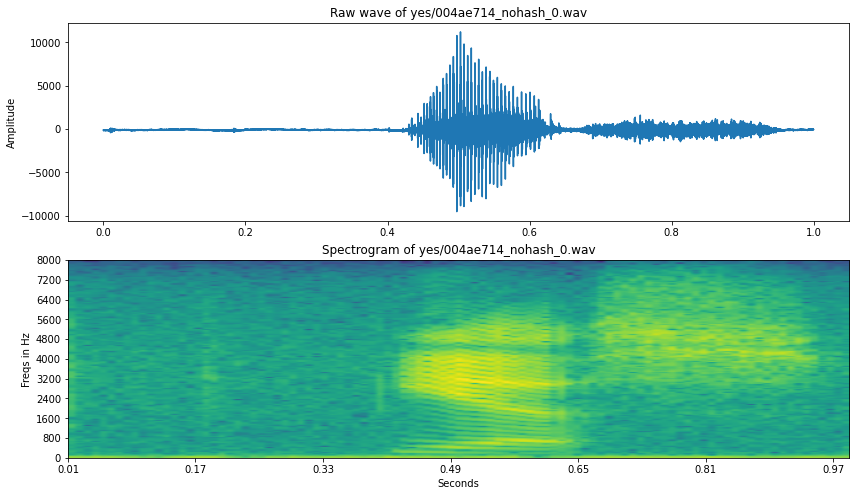

In [ ]:
train_audio_path = 'train/audio/'
filename = 'yes/004ae714_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

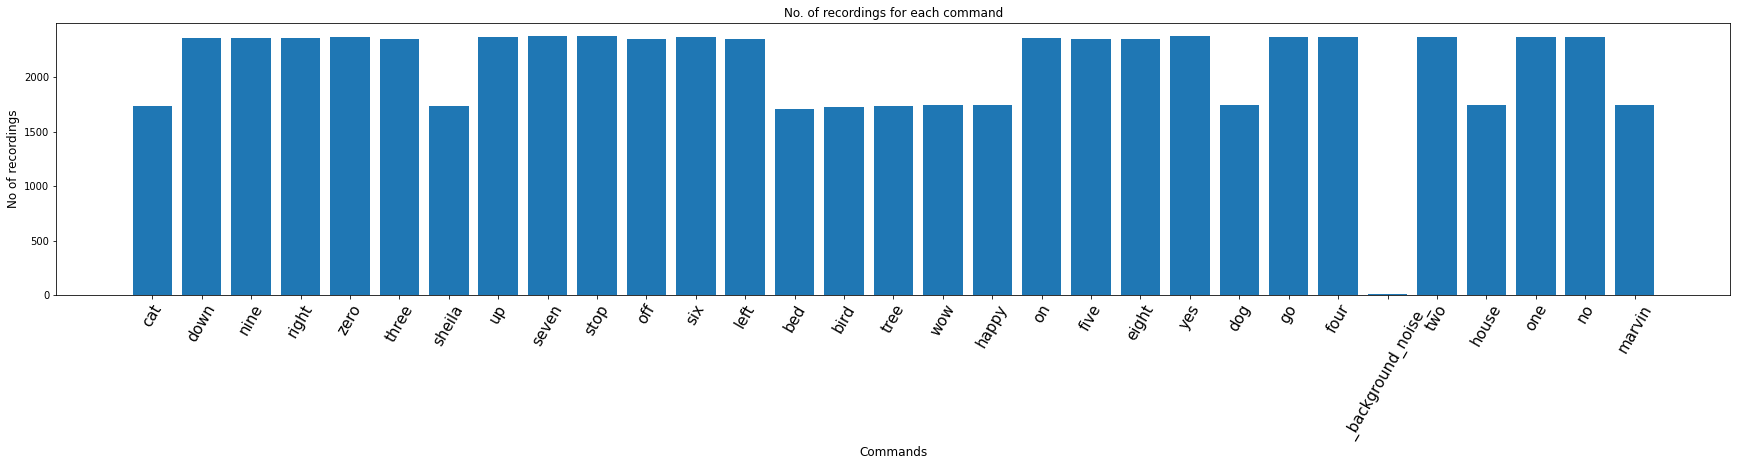

In [ ]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [ ]:
labels

['cat',
 'down',
 'nine',
 'right',
 'zero',
 'three',
 'sheila',
 'up',
 'seven',
 'stop',
 'off',
 'six',
 'left',
 'bed',
 'bird',
 'tree',
 'wow',
 'happy',
 'on',
 'five',
 'eight',
 'yes',
 'dog',
 'go',
 'four',
 '_background_noise_',
 'two',
 'house',
 'one',
 'no',
 'marvin']

In [ ]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

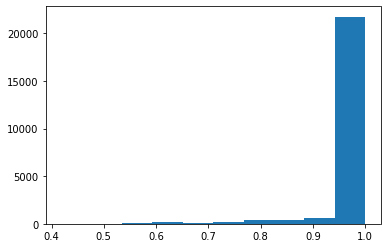

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [ ]:
train_audio_path = 'train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
all_wave = np.array(all_wave).reshape(-1,8000,1)
all_wave.shape

(21312, 8000, 1)

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - ETA: 0s - loss: 2.3010 - accuracy: 0.1019

533/533 [==============================] - 17s 9ms/step - loss: 2.3010 - accuracy: 0.1019 - val_loss: 2.2991 - val_accuracy: 0.1208
Epoch 2/100
528/533 [============================>.] - ETA: 0s - loss: 2.2949 - accuracy: 0.1240

533/533 [==============================] - 4s 8ms/step - loss: 2.2948 - accuracy: 0.1239 - val_loss: 2.2938 - val_accuracy: 0.1243
Epoch 3/100
530/533 [============================>.] - ETA: 0s - loss: 2.2851 - accuracy: 0.1286

533/533 [==============================] - 4s 8ms/step - loss: 2.2850 - accuracy: 0.1286 - val_loss: 2.2830 - val_accuracy: 0.1375
Epoch 4/100
530/533 [============================>.] - ETA: 0s - loss: 2.2740 - accuracy: 0.1374

533/533 [==============================] - 4s 8ms/step - loss: 2.2738 - accuracy: 0.1378 - val_loss: 2.2713 - val_accuracy: 0.1438
Epoch 5/100
530/533 [============================>.] - ETA: 0s - loss: 2.2562 - accuracy: 0.1528

533/533 [==============================] - 4s 8ms/step - loss: 2.2561 - accuracy: 0.1528 - val_loss: 2.2462 - val_accuracy: 0.1529
Epoch 6/100
528/533 [============================>.] - ETA: 0s - loss: 2.2310 - accuracy: 0.1628

533/533 [==============================] - 4s 8ms/step - loss: 2.2313 - accuracy: 0.1629 - val_loss: 2.2090 - val_accuracy: 0.1726
Epoch 7/100
531/533 [============================>.] - ETA: 0s - loss: 2.1831 - accuracy: 0.1883

533/533 [==============================] - 5s 10ms/step - loss: 2.1831 - accuracy: 0.1881 - val_loss: 2.1365 - val_accuracy: 0.2210
Epoch 8/100
532/533 [============================>.] - ETA: 0s - loss: 2.1378 - accuracy: 0.2018

533/533 [==============================] - 4s 8ms/step - loss: 2.1375 - accuracy: 0.2019 - val_loss: 2.0902 - val_accuracy: 0.2348
Epoch 9/100
531/533 [============================>.] - ETA: 0s - loss: 2.0917 - accuracy: 0.2192

533/533 [==============================] - 4s 8ms/step - loss: 2.0916 - accuracy: 0.2192 - val_loss: 2.0484 - val_accuracy: 0.2519
Epoch 10/100
531/533 [============================>.] - ETA: 0s - loss: 2.0365 - accuracy: 0.2382

533/533 [==============================] - 4s 8ms/step - loss: 2.0364 - accuracy: 0.2383 - val_loss: 1.9708 - val_accuracy: 0.2813
Epoch 11/100
526/533 [============================>.] - ETA: 0s - loss: 1.9516 - accuracy: 0.2684

533/533 [==============================] - 4s 8ms/step - loss: 1.9512 - accuracy: 0.2682 - val_loss: 1.8479 - val_accuracy: 0.3315
Epoch 12/100
533/533 [==============================] - ETA: 0s - loss: 1.8534 - accuracy: 0.3061

533/533 [==============================] - 5s 9ms/step - loss: 1.8534 - accuracy: 0.3061 - val_loss: 1.7400 - val_accuracy: 0.3697
Epoch 13/100
528/533 [============================>.] - ETA: 0s - loss: 1.7653 - accuracy: 0.3387

533/533 [==============================] - 4s 8ms/step - loss: 1.7635 - accuracy: 0.3393 - val_loss: 1.7713 - val_accuracy: 0.3521
Epoch 14/100
528/533 [============================>.] - ETA: 0s - loss: 1.6738 - accuracy: 0.3732

533/533 [==============================] - 4s 8ms/step - loss: 1.6726 - accuracy: 0.3734 - val_loss: 1.6398 - val_accuracy: 0.4091
Epoch 15/100
527/533 [============================>.] - ETA: 0s - loss: 1.5958 - accuracy: 0.4056

533/533 [==============================] - 4s 8ms/step - loss: 1.5965 - accuracy: 0.4053 - val_loss: 1.5427 - val_accuracy: 0.4516
Epoch 16/100
527/533 [============================>.] - ETA: 0s - loss: 1.5246 - accuracy: 0.4317

533/533 [==============================] - 4s 8ms/step - loss: 1.5232 - accuracy: 0.4323 - val_loss: 1.4647 - val_accuracy: 0.4586
Epoch 17/100
528/533 [============================>.] - ETA: 0s - loss: 1.4595 - accuracy: 0.4589

533/533 [==============================] - 4s 8ms/step - loss: 1.4597 - accuracy: 0.4585 - val_loss: 1.3862 - val_accuracy: 0.5182
Epoch 18/100
531/533 [============================>.] - ETA: 0s - loss: 1.4002 - accuracy: 0.4849

533/533 [==============================] - 4s 8ms/step - loss: 1.3998 - accuracy: 0.4851 - val_loss: 1.3603 - val_accuracy: 0.5191
Epoch 19/100
530/533 [============================>.] - ETA: 0s - loss: 1.3497 - accuracy: 0.5084

533/533 [==============================] - 4s 8ms/step - loss: 1.3486 - accuracy: 0.5085 - val_loss: 1.2595 - val_accuracy: 0.5635
Epoch 20/100
531/533 [============================>.] - ETA: 0s - loss: 1.2995 - accuracy: 0.5262

533/533 [==============================] - 4s 8ms/step - loss: 1.3000 - accuracy: 0.5262 - val_loss: 1.2023 - val_accuracy: 0.5803
Epoch 21/100
530/533 [============================>.] - ETA: 0s - loss: 1.2594 - accuracy: 0.5403

533/533 [==============================] - 4s 8ms/step - loss: 1.2592 - accuracy: 0.5405 - val_loss: 1.2640 - val_accuracy: 0.5642
Epoch 22/100
531/533 [============================>.] - ETA: 0s - loss: 1.2208 - accuracy: 0.5586

533/533 [==============================] - 4s 8ms/step - loss: 1.2205 - accuracy: 0.5587 - val_loss: 1.1691 - val_accuracy: 0.5900
Epoch 23/100
530/533 [============================>.] - ETA: 0s - loss: 1.1749 - accuracy: 0.5771

533/533 [==============================] - 4s 8ms/step - loss: 1.1750 - accuracy: 0.5773 - val_loss: 1.2307 - val_accuracy: 0.5817
Epoch 24/100
527/533 [============================>.] - ETA: 0s - loss: 1.1483 - accuracy: 0.5787

533/533 [==============================] - 4s 8ms/step - loss: 1.1478 - accuracy: 0.5796 - val_loss: 1.0763 - val_accuracy: 0.6341
Epoch 25/100
527/533 [============================>.] - ETA: 0s - loss: 1.1054 - accuracy: 0.5984

533/533 [==============================] - 5s 8ms/step - loss: 1.1047 - accuracy: 0.5990 - val_loss: 1.1109 - val_accuracy: 0.6266
Epoch 26/100
528/533 [============================>.] - ETA: 0s - loss: 1.0823 - accuracy: 0.6140

533/533 [==============================] - 4s 8ms/step - loss: 1.0826 - accuracy: 0.6143 - val_loss: 1.0636 - val_accuracy: 0.6327
Epoch 27/100
530/533 [============================>.] - ETA: 0s - loss: 1.0525 - accuracy: 0.6242

533/533 [==============================] - 4s 8ms/step - loss: 1.0528 - accuracy: 0.6238 - val_loss: 0.9784 - val_accuracy: 0.6617
Epoch 28/100
530/533 [============================>.] - ETA: 0s - loss: 1.0171 - accuracy: 0.6379

533/533 [==============================] - 4s 8ms/step - loss: 1.0169 - accuracy: 0.6379 - val_loss: 1.0308 - val_accuracy: 0.6441
Epoch 29/100
526/533 [============================>.] - ETA: 0s - loss: 1.0018 - accuracy: 0.6422

533/533 [==============================] - 4s 8ms/step - loss: 1.0027 - accuracy: 0.6418 - val_loss: 0.9320 - val_accuracy: 0.6831
Epoch 30/100
533/533 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.6500

533/533 [==============================] - 4s 8ms/step - loss: 0.9739 - accuracy: 0.6500 - val_loss: 0.9217 - val_accuracy: 0.6861
Epoch 31/100
527/533 [============================>.] - ETA: 0s - loss: 0.9621 - accuracy: 0.6552

533/533 [==============================] - 4s 8ms/step - loss: 0.9625 - accuracy: 0.6547 - val_loss: 0.9329 - val_accuracy: 0.6789
Epoch 32/100
530/533 [============================>.] - ETA: 0s - loss: 0.9467 - accuracy: 0.6615

533/533 [==============================] - 4s 8ms/step - loss: 0.9472 - accuracy: 0.6612 - val_loss: 0.9301 - val_accuracy: 0.6798
Epoch 33/100
527/533 [============================>.] - ETA: 0s - loss: 0.9164 - accuracy: 0.6729

533/533 [==============================] - 4s 8ms/step - loss: 0.9177 - accuracy: 0.6728 - val_loss: 0.9128 - val_accuracy: 0.6831
Epoch 34/100
528/533 [============================>.] - ETA: 0s - loss: 0.8936 - accuracy: 0.6810

533/533 [==============================] - 5s 9ms/step - loss: 0.8934 - accuracy: 0.6809 - val_loss: 0.9220 - val_accuracy: 0.6775
Epoch 35/100
533/533 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.6837

533/533 [==============================] - 5s 10ms/step - loss: 0.8849 - accuracy: 0.6837 - val_loss: 0.8728 - val_accuracy: 0.6976
Epoch 36/100
528/533 [============================>.] - ETA: 0s - loss: 0.8645 - accuracy: 0.6903

533/533 [==============================] - 5s 9ms/step - loss: 0.8661 - accuracy: 0.6895 - val_loss: 0.8658 - val_accuracy: 0.6990
Epoch 37/100
529/533 [============================>.] - ETA: 0s - loss: 0.8425 - accuracy: 0.7011

533/533 [==============================] - 4s 8ms/step - loss: 0.8429 - accuracy: 0.7006 - val_loss: 0.9937 - val_accuracy: 0.6582
Epoch 38/100
530/533 [============================>.] - ETA: 0s - loss: 0.8405 - accuracy: 0.6986

533/533 [==============================] - 4s 8ms/step - loss: 0.8411 - accuracy: 0.6985 - val_loss: 0.8678 - val_accuracy: 0.7011
Epoch 39/100
533/533 [==============================] - ETA: 0s - loss: 0.8261 - accuracy: 0.7029

533/533 [==============================] - 5s 8ms/step - loss: 0.8261 - accuracy: 0.7029 - val_loss: 0.8720 - val_accuracy: 0.6958
Epoch 40/100
527/533 [============================>.] - ETA: 0s - loss: 0.8077 - accuracy: 0.7109

533/533 [==============================] - 5s 8ms/step - loss: 0.8076 - accuracy: 0.7105 - val_loss: 0.8496 - val_accuracy: 0.7087
Epoch 41/100
530/533 [============================>.] - ETA: 0s - loss: 0.7944 - accuracy: 0.7123

533/533 [==============================] - 5s 8ms/step - loss: 0.7950 - accuracy: 0.7120 - val_loss: 0.8390 - val_accuracy: 0.7133
Epoch 42/100
527/533 [============================>.] - ETA: 0s - loss: 0.7817 - accuracy: 0.7198

533/533 [==============================] - 5s 9ms/step - loss: 0.7822 - accuracy: 0.7192 - val_loss: 0.8476 - val_accuracy: 0.7131
Epoch 43/100
528/533 [============================>.] - ETA: 0s - loss: 0.7685 - accuracy: 0.7263

533/533 [==============================] - 5s 8ms/step - loss: 0.7693 - accuracy: 0.7258 - val_loss: 0.8293 - val_accuracy: 0.7117
Epoch 44/100
529/533 [============================>.] - ETA: 0s - loss: 0.7506 - accuracy: 0.7325

533/533 [==============================] - 5s 9ms/step - loss: 0.7502 - accuracy: 0.7324 - val_loss: 0.8269 - val_accuracy: 0.7103
Epoch 45/100
529/533 [============================>.] - ETA: 0s - loss: 0.7396 - accuracy: 0.7371

533/533 [==============================] - 4s 8ms/step - loss: 0.7397 - accuracy: 0.7372 - val_loss: 0.7719 - val_accuracy: 0.7342
Epoch 46/100
526/533 [============================>.] - ETA: 0s - loss: 0.7256 - accuracy: 0.7386

533/533 [==============================] - 5s 9ms/step - loss: 0.7262 - accuracy: 0.7380 - val_loss: 0.8189 - val_accuracy: 0.7199
Epoch 47/100
527/533 [============================>.] - ETA: 0s - loss: 0.7114 - accuracy: 0.7445

533/533 [==============================] - 5s 9ms/step - loss: 0.7111 - accuracy: 0.7446 - val_loss: 0.7733 - val_accuracy: 0.7323
Epoch 48/100
529/533 [============================>.] - ETA: 0s - loss: 0.7072 - accuracy: 0.7447

533/533 [==============================] - 5s 9ms/step - loss: 0.7055 - accuracy: 0.7454 - val_loss: 0.7622 - val_accuracy: 0.7366
Epoch 49/100
528/533 [============================>.] - ETA: 0s - loss: 0.6900 - accuracy: 0.7521

533/533 [==============================] - 5s 9ms/step - loss: 0.6897 - accuracy: 0.7523 - val_loss: 0.7713 - val_accuracy: 0.7384
Epoch 50/100
528/533 [============================>.] - ETA: 0s - loss: 0.6754 - accuracy: 0.7574

533/533 [==============================] - 4s 8ms/step - loss: 0.6761 - accuracy: 0.7574 - val_loss: 0.7958 - val_accuracy: 0.7253
Epoch 51/100
531/533 [============================>.] - ETA: 0s - loss: 0.6783 - accuracy: 0.7561

533/533 [==============================] - 5s 9ms/step - loss: 0.6780 - accuracy: 0.7562 - val_loss: 0.7499 - val_accuracy: 0.7497
Epoch 52/100
531/533 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.7635

533/533 [==============================] - 5s 9ms/step - loss: 0.6581 - accuracy: 0.7634 - val_loss: 0.7755 - val_accuracy: 0.7431
Epoch 53/100
529/533 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.7700

533/533 [==============================] - 5s 9ms/step - loss: 0.6506 - accuracy: 0.7702 - val_loss: 0.7359 - val_accuracy: 0.7525
Epoch 54/100
530/533 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.7747

533/533 [==============================] - 4s 8ms/step - loss: 0.6312 - accuracy: 0.7747 - val_loss: 0.7770 - val_accuracy: 0.7316
Epoch 55/100
528/533 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.7757

533/533 [==============================] - 4s 8ms/step - loss: 0.6285 - accuracy: 0.7759 - val_loss: 0.7430 - val_accuracy: 0.7530
Epoch 56/100
528/533 [============================>.] - ETA: 0s - loss: 0.6185 - accuracy: 0.7760

533/533 [==============================] - 4s 8ms/step - loss: 0.6182 - accuracy: 0.7761 - val_loss: 0.7329 - val_accuracy: 0.7490
Epoch 57/100
530/533 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.7777

533/533 [==============================] - 5s 9ms/step - loss: 0.6121 - accuracy: 0.7773 - val_loss: 0.7679 - val_accuracy: 0.7382
Epoch 58/100
527/533 [============================>.] - ETA: 0s - loss: 0.6034 - accuracy: 0.7813

533/533 [==============================] - 5s 9ms/step - loss: 0.6028 - accuracy: 0.7814 - val_loss: 0.7052 - val_accuracy: 0.7591
Epoch 59/100
532/533 [============================>.] - ETA: 0s - loss: 0.5858 - accuracy: 0.7877

533/533 [==============================] - 4s 8ms/step - loss: 0.5861 - accuracy: 0.7876 - val_loss: 0.7298 - val_accuracy: 0.7567
Epoch 60/100
529/533 [============================>.] - ETA: 0s - loss: 0.5882 - accuracy: 0.7880

533/533 [==============================] - 4s 8ms/step - loss: 0.5879 - accuracy: 0.7881 - val_loss: 0.7129 - val_accuracy: 0.7565
Epoch 61/100
531/533 [============================>.] - ETA: 0s - loss: 0.5681 - accuracy: 0.7957

533/533 [==============================] - 5s 9ms/step - loss: 0.5685 - accuracy: 0.7955 - val_loss: 0.7046 - val_accuracy: 0.7600
Epoch 62/100
531/533 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.7974

533/533 [==============================] - 5s 9ms/step - loss: 0.5577 - accuracy: 0.7976 - val_loss: 0.7288 - val_accuracy: 0.7631
Epoch 63/100
526/533 [============================>.] - ETA: 0s - loss: 0.5532 - accuracy: 0.7979

533/533 [==============================] - 4s 8ms/step - loss: 0.5549 - accuracy: 0.7975 - val_loss: 0.7412 - val_accuracy: 0.7549
Epoch 64/100
529/533 [============================>.] - ETA: 0s - loss: 0.5483 - accuracy: 0.7998

533/533 [==============================] - 5s 9ms/step - loss: 0.5484 - accuracy: 0.7999 - val_loss: 0.7064 - val_accuracy: 0.7652
Epoch 65/100
528/533 [============================>.] - ETA: 0s - loss: 0.5402 - accuracy: 0.8041

533/533 [==============================] - 4s 8ms/step - loss: 0.5395 - accuracy: 0.8042 - val_loss: 0.6921 - val_accuracy: 0.7685
Epoch 66/100
528/533 [============================>.] - ETA: 0s - loss: 0.5219 - accuracy: 0.8116

533/533 [==============================] - 4s 8ms/step - loss: 0.5215 - accuracy: 0.8118 - val_loss: 0.7755 - val_accuracy: 0.7490
Epoch 67/100
531/533 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.8100

533/533 [==============================] - 5s 9ms/step - loss: 0.5295 - accuracy: 0.8101 - val_loss: 0.7105 - val_accuracy: 0.7633
Epoch 68/100
528/533 [============================>.] - ETA: 0s - loss: 0.5150 - accuracy: 0.8175

533/533 [==============================] - 4s 8ms/step - loss: 0.5152 - accuracy: 0.8175 - val_loss: 0.6781 - val_accuracy: 0.7757
Epoch 69/100
527/533 [============================>.] - ETA: 0s - loss: 0.5129 - accuracy: 0.8163

533/533 [==============================] - 5s 9ms/step - loss: 0.5129 - accuracy: 0.8160 - val_loss: 0.7544 - val_accuracy: 0.7558
Epoch 70/100
527/533 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.8175

533/533 [==============================] - 4s 8ms/step - loss: 0.5050 - accuracy: 0.8178 - val_loss: 0.7471 - val_accuracy: 0.7619
Epoch 71/100
527/533 [============================>.] - ETA: 0s - loss: 0.4939 - accuracy: 0.8206

533/533 [==============================] - 4s 8ms/step - loss: 0.4942 - accuracy: 0.8203 - val_loss: 0.7011 - val_accuracy: 0.7694
Epoch 72/100
532/533 [============================>.] - ETA: 0s - loss: 0.4960 - accuracy: 0.8193

533/533 [==============================] - 4s 8ms/step - loss: 0.4964 - accuracy: 0.8189 - val_loss: 0.7152 - val_accuracy: 0.7668
Epoch 73/100
533/533 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.8250

533/533 [==============================] - 4s 8ms/step - loss: 0.4863 - accuracy: 0.8250 - val_loss: 0.7226 - val_accuracy: 0.7652
Epoch 74/100
527/533 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.8278

533/533 [==============================] - 5s 9ms/step - loss: 0.4745 - accuracy: 0.8280 - val_loss: 0.7298 - val_accuracy: 0.7624
Epoch 75/100
526/533 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.8357

533/533 [==============================] - 4s 8ms/step - loss: 0.4655 - accuracy: 0.8353 - val_loss: 0.6959 - val_accuracy: 0.7718
Epoch 76/100
532/533 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.8375

533/533 [==============================] - 4s 8ms/step - loss: 0.4524 - accuracy: 0.8375 - val_loss: 0.7128 - val_accuracy: 0.7760
Epoch 77/100
528/533 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8364

533/533 [==============================] - 4s 8ms/step - loss: 0.4505 - accuracy: 0.8369 - val_loss: 0.7251 - val_accuracy: 0.7706
Epoch 78/100
533/533 [==============================] - ETA: 0s - loss: 0.4482 - accuracy: 0.8405

533/533 [==============================] - 4s 8ms/step - loss: 0.4482 - accuracy: 0.8405 - val_loss: 0.6858 - val_accuracy: 0.7823
Epoch 78: early stopping


In [ ]:
model.save_weights('content/')

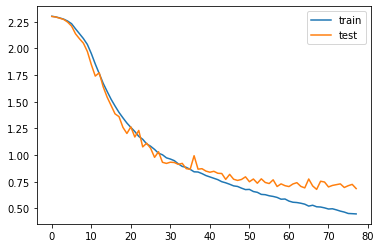

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()
plt.show()

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,len(audio),1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
import IPython.display as ipd
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: up
Text: off


In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1.07):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'  # or webm ?

In [ ]:
voice=record()
s,sr=librosa.load(voice,16000)

predict(librosa.resample(s,sr,8000)[:8000])

<IPython.core.display.Javascript object>

'up'